In [183]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from functools import reduce

In [232]:
FRONT_MASK_01 = cv2.imread('./front_vision_mask_01.png', 0)
FRONT_MASK_02 = cv2.imread('./front_vision_mask_02.png', 0)

DEFAULT_SEG_CRT = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

DARK_AREA_CROP_YY_THRESH = 325

RIGHT_VISION_HIGH_POINT=np.array((355, 145))
RIGHT_VISION_LOW_POINT=np.array((165, 145))

LEFT_VISION_HIGH_POINT=np.array((415, 315))
LEFT_VISION_LOW_POINT=np.array((215, 325))

FRONT_VISION_LEFT_POINT=np.array((200, 300))
FRONT_VISION_RIGHT_POINT=np.array((440, 300))


def mask_image(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)


def kmeans_segmentation(image, attempts = 10, k = 4, criteria = DEFAULT_SEG_CRT):
    td_img = np.float32(image.reshape((-1, 3)))
    _, label, center = cv2.kmeans(td_img, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]

    return res.reshape((image.shape))


def detect_color_profile(image, lower_bound, upper_bound, blur_image = False):
    if blur_image is True:
        image = cv2.GaussianBlur(image, (5, 5), 0)
    color_mask = cv2.inRange(image, lower_bound, upper_bound)
    return cv2.bitwise_and(image, image, mask=color_mask)


def detect_plants(image, lower_adjust = -10, upper_adjust = 10, image_is_hsv = False):
    if not image_is_hsv:
        image = convert_image_to_hsv(image)
    return detect_color_profile(
        image=image,
        lower_bound=np.array((63, 166, 137)) + lower_adjust,
        upper_bound=np.array([65, 208, 157]) + upper_adjust,
        blur_image=False,
    )


def detect_stake(image, lower_adjust = -10, upper_adjust = 10, image_is_hsv = False):
    if not image_is_hsv:
        image = convert_image_to_hsv(image)
    return detect_color_profile(
        image=image,
        lower_bound=np.array((20, 131, 166)) + lower_adjust,
        upper_bound=np.array((22, 192, 196)) + upper_adjust,
        blur_image=False,
    )


def convert_image_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV_FULL)


def canny(image, thresh1 = 50, thresh2 = 100, blur_image = False):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if blur_image is True:
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

    return cv2.Canny(gray, thresh1, thresh2)


def make_coordinates(image, line_params):
    slope, intercept = line_params
    y1 = image.shape[0]
    y2 = int(y1 * 0.8)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])


def average_slope_intercep(image, lines):
    left_fit = []
    right_fit = []
    for x1, y1, x2, y2 in lines.reshape(-1, 4):
        params = np.polyfit((x1, x2), (y1, y2), 1)
        slope = params[0]
        intercept = params[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])


def hough_lines(image, min_line_len = 20, max_line_gap = 20, image_is_canny = False):
    if not image_is_canny:
        image = canny(image, blur_image = True)
    return cv2.HoughLinesP(image, 2, np.pi / 180, 10, np.array([]), min_line_len, max_line_gap)


def draw_lines_on_image(image, lines, color_rgb = (255, 0, 0)):
    line_image = np.zeros_like(image)

    if lines is not None:
        for x1, y1, x2, y2 in lines.reshape(-1, 4):
            cv2.line(line_image, (x1, y1), (x2, y2), color_rgb, 10)

    return cv2.addWeighted(image, 0.8, line_image, 1, 1)


def crop_front_image(image, yy_thresh = DARK_AREA_CROP_YY_THRESH):
    return image[0:yy_thresh, ::]


def crop_lateral_image(image, xx_thresh = 60):
    return image[::, xx_thresh::]

In [262]:
def line_dist_to_point(line, point):
    x1, y1, x2, y2 = line
    x0, y0 = point
    mod = np.abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
    ro = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return mod / ro


def define_lateral_line_reducer(highest_point, lowest_point):
    def reduce_function(a, b):
        lhw = line_dist_to_point(a, highest_point)
        llw = line_dist_to_point(a, lowest_point)
        rhw = line_dist_to_point(b, highest_point)
        rlh = line_dist_to_point(b, lowest_point)
        dist_a = np.sqrt(llw**2 + lhw**2)
        dist_b = np.sqrt(rhw**2 + rlh**2)
        return a if dist_a < dist_b else b
    return reduce_function


def define_frontal_line_reducer(point):
    def reduce_funtion(a, b):
        dist_a = line_dist_to_point(a, point)
        dist_b = line_dist_to_point(b, point)
        return a if dist_a < dist_b else b
    return reduce_funtion

In [268]:
left = crop_lateral_image(cv2.imread('./left_cam_example.png'))
right = crop_lateral_image(cv2.imread('./right_cam_example.png'))
front = crop_front_image(cv2.imread('./robot_camera_example.png'))

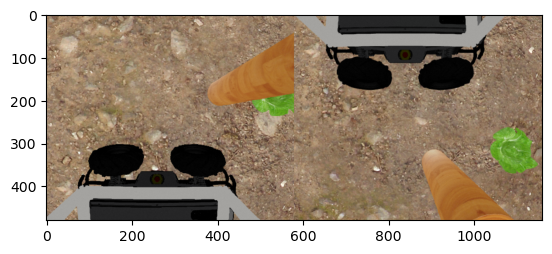

In [269]:
plt.imshow(np.hstack((left, right)))

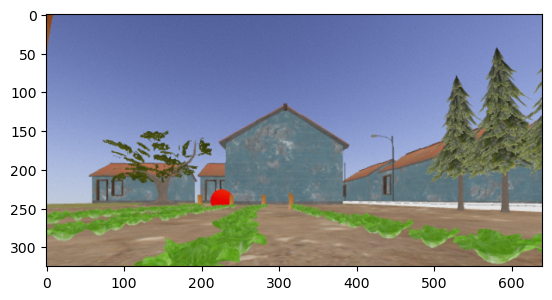

In [270]:
plt.imshow(front)

In [271]:
left_hsv = convert_image_to_hsv(left)
right_hsv = convert_image_to_hsv(right)
front_hsv = convert_image_to_hsv(front)

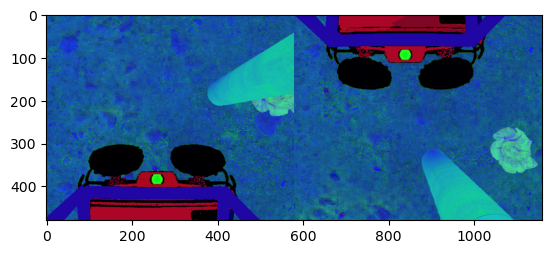

In [272]:
plt.imshow(np.hstack((left_hsv, right_hsv)))

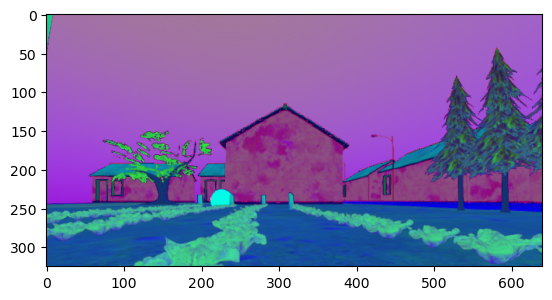

In [302]:
plt.imshow(front_hsv)

In [303]:
left_stake = detect_stake(left_hsv, image_is_hsv=True)
left_plants = detect_plants(left_hsv, image_is_hsv=True)
right_stake = detect_stake(right_hsv, image_is_hsv=True)
right_plants = detect_plants(right_hsv, image_is_hsv=True)
front_plants = detect_plants(front_hsv, image_is_hsv=True)
front_stake = detect_stake(front_hsv, image_is_hsv=True)

In [304]:
left_stake_lines = hough_lines(left_stake)
left_plants_lines = hough_lines(left_plants)
right_stake_lines = hough_lines(right_stake)
right_plants_lines = hough_lines(right_plants)
front_stake_lines = hough_lines(front_stake)
front_plants_lines = hough_lines(front_plants)

left_image = draw_lines_on_image(left, left_plants_lines)
left_image = draw_lines_on_image(left_image, left_stake_lines, (0, 100, 150))

right_image = draw_lines_on_image(right, right_plants_lines)
right_image = draw_lines_on_image(right_image, right_stake_lines, (0, 100, 150))

front_image = draw_lines_on_image(front, front_plants_lines)
front_image = draw_lines_on_image(front_image, front_stake_lines, (0, 100, 150))

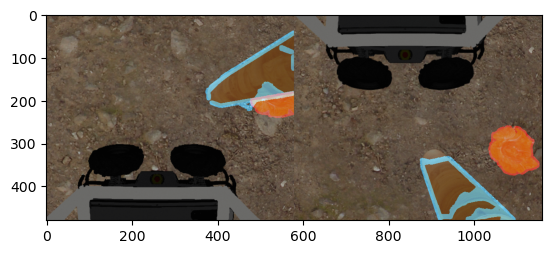

In [305]:
plt.imshow(np.hstack((left_image, right_image)))

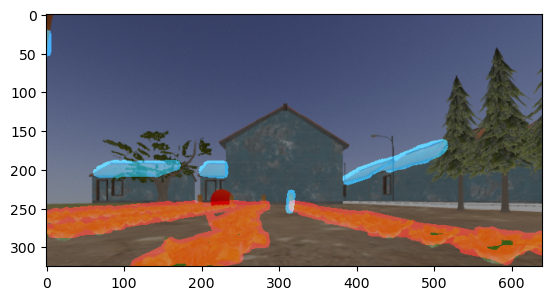

In [311]:
plt.imshow(front_image)

In [312]:
left_line_reducer = define_lateral_line_reducer(LEFT_VISION_HIGH_POINT, LEFT_VISION_LOW_POINT)
right_line_reducer = define_lateral_line_reducer(RIGHT_VISION_HIGH_POINT, RIGHT_VISION_LOW_POINT)

In [313]:
closest_left_stake_line = reduce(left_line_reducer, left_stake_lines.reshape(-1, 4))
closest_right_stake_line = reduce(right_line_reducer, right_stake_lines.reshape(-1, 4))
closest_left_plant_line = reduce(left_line_reducer, left_plants_lines.reshape(-1, 4))
closest_right_plant_line = reduce(right_line_reducer, right_plants_lines.reshape(-1, 4))

In [314]:
left_lines = np.hstack((closest_left_stake_line, closest_left_plant_line)).reshape(-1, 1, 4)
right_lines = np.hstack((closest_right_stake_line, closest_right_plant_line)).reshape(-1, 1, 4)

In [315]:
left_image = draw_lines_on_image(left, left_lines)
right_image = draw_lines_on_image(right, right_lines)

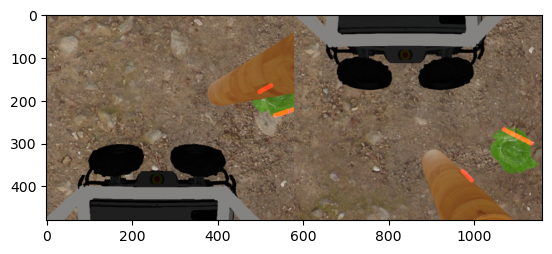

In [316]:
plt.imshow(np.hstack((left_image, right_image)))

In [320]:
front_right_line_reducer = define_frontal_line_reducer(FRONT_VISION_RIGHT_POINT)
front_left_line_reducer = define_frontal_line_reducer(FRONT_VISION_LEFT_POINT)

In [321]:
closest_front_left_plant_line = reduce(front_left_line_reducer, front_plants_lines.reshape(-1, 4))
closest_front_right_plant_line = reduce(front_right_line_reducer, front_plants_lines.reshape(-1, 4))
closest_front_left_stake_line = reduce(front_left_line_reducer, front_stake_lines.reshape(-1, 4))
closest_front_right_stake_line = reduce(front_left_line_reducer, front_stake_lines.reshape(-1, 4))

In [322]:
front_left_lines = np.hstack((closest_front_left_plant_line, closest_front_left_stake_line)).reshape(-1, 1, 4)
front_right_lines = np.hstack((closest_front_right_plant_line, closest_front_right_stake_line)).reshape(-1, 1, 4)

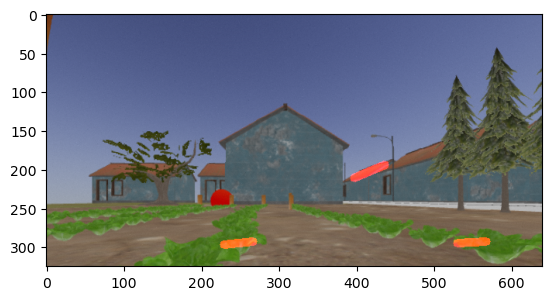

In [324]:
front_image = draw_lines_on_image(front, np.hstack((front_left_lines, front_right_lines)).reshape(-1, 1, 4))
plt.imshow(front_image)